In [ ]:
!pip install pyspark tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
spark = SparkSession.builder.appName("TeslaStockPrediction").getOrCreate()



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving TSLA.csv to TSLA.csv


In [ ]:
df = pd.read_csv("/content/TSLA.csv", parse_dates=True, index_col='Date')
print(df.head())

             Open   High    Low  Close  Adj Close    Volume
Date                                                       
2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500


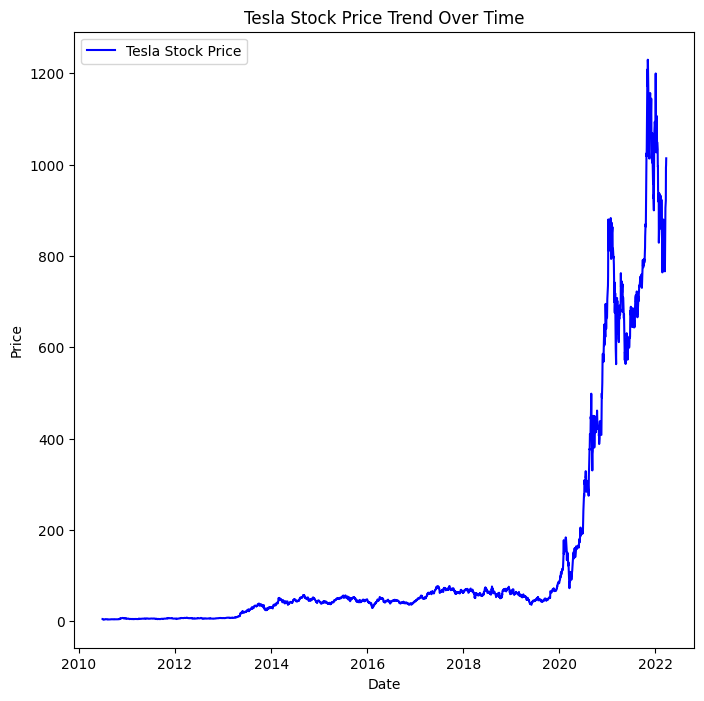

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(df.index, df['Close'], color='blue', label='Tesla Stock Price')
plt.title('Tesla Stock Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
df = df[['Close']]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))


In [ ]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)


In [ ]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)


In [ ]:

# Reshape data for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 2.4186e-04 - val_loss: 0.0030
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 7.3193e-06 - val_loss: 0.0025
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 5.5098e-06 - val_loss: 0.0029
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 5.3314e-06 - val_loss: 0.0030
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 6.8396e-06 - val_loss: 0.0022
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 4.8821e-06 - val_loss: 0.0020
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 4.2486e-06 - val_loss: 0.0020
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 4.4372e-06 - val_loss: 0.0025
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 5.0834e-06 - val_loss: 0.0017
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 5.5135e-06 - val_loss: 0.0019
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 4.2448e-06 - val_loss: 0.0023
Epoch 12/50
72/7

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
real_stock_price = scaler.inverse_transform(y_test.reshape(-1, 1))

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


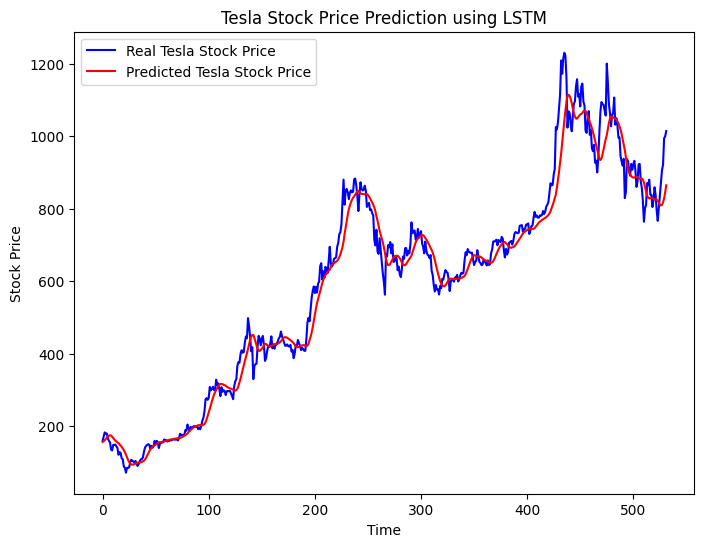

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(real_stock_price, color='blue', label='Real Tesla Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
r2 = r2_score(real_stock_price, predicted_stock_price)
accuracy = 100 - np.mean(np.abs((real_stock_price - predicted_stock_price) / real_stock_price)) * 100
print(f"R-squared (R²): {r2}")
print(f"Accuracy: {accuracy}%")

R-squared (R²): 0.9703949824202844
Accuracy: 93.61850782486685%


In [ ]:
#predicting next 30 days stock prices
future_steps = 30
last_data = scaled_data[-60:]
last_data = last_data.reshape(1, 60, 1)

In [ ]:

future_predictions = model.predict(last_data)
future_predictions = scaler.inverse_transform(future_predictions)

print(f"Predicted Tesla stock price for the next {future_steps} days: {future_predictions}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Tesla stock price for the next 30 days: [[885.8333]]
